<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

### Задача определения частей речи, Part-Of-Speech Tagger (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM).

In [82]:
import nltk
import pandas as pd
import numpy as np
from collections import OrderedDict, deque
from nltk.corpus import brown
import matplotlib.pyplot as plt

from nltk.probability import FreqDist

Библиотека по обработке текста http://www.nltk.org/book/

Загрузим brown корпус

In [83]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

Существует не одна система тегирования, поэтому , когда прогнозируем тег слов в тексте и вычисляем качество прогноза, можно получить несправедливо низкое качество решения.

Сейчас будем использовать универсальную систему тегирования universal_tagset 

In [84]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

<img src="https://4.bp.blogspot.com/-IcFli2wljs0/WrVCw3umY_I/AAAAAAAACYM/UJ_neoUAs3wF95dj2Ouf3BzxXzB_b2TbQCLcBGAs/s1600/postags.png">


Мы имеем массив предложений пар (слово-тег)

In [203]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
brown_tagged_sents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

Первое предложение

In [ ]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Все пары (слово-тег)

In [86]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

Проанализируйтем данные, с которыми работаетем. Используем `nltk.FreqDist()` для подсчета частоты встречаемости тега и слова в нашем корпусе. Под частой элемента подразумевается кол-во этого элемента в корпусе.

In [6]:
# Приведем слова к нижнему регистру
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [87]:
print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words] # наши теги
words = [word for (word, tag) in brown_tagged_words] # наши слова

tag_num = pd.Series(FreqDist(pd.Series(tags))).sort_values(ascending=False)
words_num = pd.Series(FreqDist(pd.Series(words))).sort_values(ascending=False)

Кол-во предложений:  57340


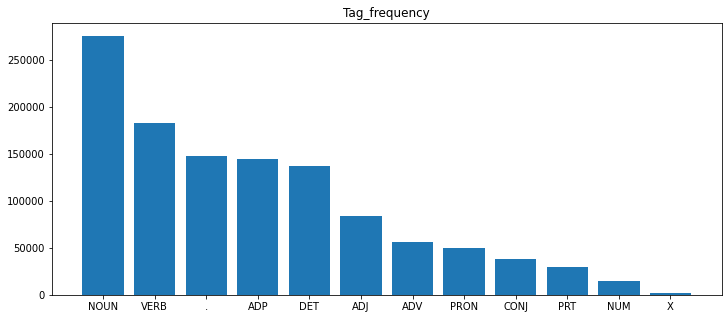

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(tag_num.index[0:20], tag_num.values[0:20])
plt.title("Tag_frequency")
plt.show()

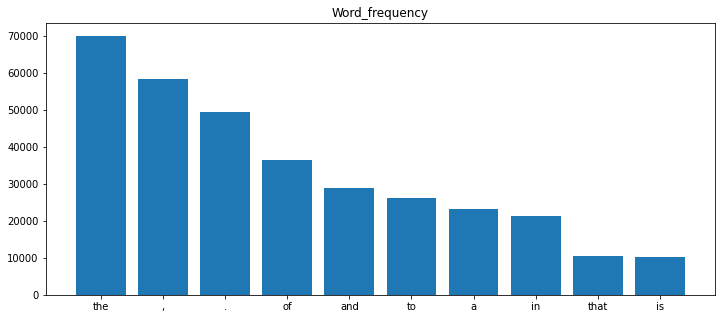

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(words_num.index[:10], words_num.values[:10])
plt.title("Word_frequency")
plt.show()

Кол-во слова `cat` в корпусе

In [ ]:
words_num['cat']

23

Самое популярное слово с самым популярным тегом? (сначала выбираем слова с самым популярным тегом, а затем выбираем самое популярное слово из уже выбранных)

In [88]:
most_pop_tag = tag_num.idxmax()
most_pop_word = pd.DataFrame([i for i, j in brown_tagged_words if j == most_pop_tag]).value_counts().sort_values(ascending=False).index[0][0]
most_pop_wordtag = (most_pop_word, most_pop_tag)
most_pop_wordtag

('time', 'NOUN')

Впоследствии обучение моделей может занимать слишком много времени, работаем с подвыборкой, например, только текстами определенных категорий.

Категории нашего корпуса:

In [8]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Будем работать с категорией humor

Cделаем случайное разбиение выборки на обучение и контроль в отношении 9:1. 

In [215]:
#brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents)

from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(my_brown_tagged_sents, test_size=0.1, random_state=0)

### Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
вероятность совместного появления данной последовательности слов Х и данной последовательности тегов Y
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot
p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1)
= (\text{в силу условий нашей модели}) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$ <br>
Для последовательности длины $n + 1$:<br>
$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

#### Алгоритм Витерби для применения модели


Требуется написать метод .predict для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамиеского программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [216]:
class HiddenMarkovModel:    
    def __init__(self):
    
        pass
        
    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train) 
        """
        tags = [tag for sent in train_tokens_tags_list
                for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list
                 for (word, tag) in sent]
       
        tag_num = pd.Series(FreqDist(pd.Series(tags).sort_values(ascending=False))).sort_index()
        word_num = pd.Series(FreqDist(pd.Series(words).sort_values(ascending=False))).sort_values(ascending=False)
         
        self.tags = tag_num.index
        self.words = word_num.index
        
        A = pd.DataFrame({'{}'.format(tag) : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame({'{}'.format(tag) : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)
        
        # Вычисляем матрицу A и B по частотам слов и тегов
        
        # sent - предложение
        # sent[i][0] - i слово в этом предложении, sent[i][1] - i тег в этом предложении
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                B.loc[sent[i][0], sent[i][1]] += 1 # текущая i-пара слово-тег (обновите матрицу B аналогично A)
                if len(sent) - 1 != i: # для последнего тега нет следующего тега
                    A.loc[sent[i][1], sent[i + 1][1]] += 1 # пара тег-тег
                
        
        # переходим к вероятностям
        
        # нормируем по строке, то есть по всем всевозможным следующим тегам
        A = A.divide(A.sum(axis=1), axis=0)
        
        # нормируем по столбцу, то есть по всем всевозможным текущим словам
        B = B / np.sum(B, axis=0)
        
        self.A = A
        self.B = B
        
        return self
        
    
    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений пар слово-тег (выборка для test)
        """
        predict_tags = OrderedDict({i : np.array([]) for i in range(len(test_tokens_list))})
        
        for i_sent in range(len(test_tokens_list)): # итеририумся по предложениям
            
            current_sent = test_tokens_list[i_sent] # текущее предложение
            len_sent = len(current_sent) # длина предложения 
            
            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1 # нулевое состояние (равномерная инициализация по всем s)
            back_point = np.zeros(shape=(len_sent + 1, len(self.tags))) # # argmax

            # one iteration fills row q[t]
            for t in range(len_sent): # итерируемся по словам предложения

                # если мы не встречали такое слово в обучении, то вместо него будет 
                # самое популярное слово с самым популярным тегом (вопрос 2)
                if current_sent[t] not in self.words:
                    current_sent[t] = most_pop_wordtag[0]
                
                # через max выбираем следующий тег
                for i_s in range(len(self.tags)): # iterations over tag values (here index of tag to correspond to matrix q columns)

                    s = self.tags[i_s] 

                    # формула (1)
                    q[t + 1][i_s] = np.max(q[t] * 
                        self.A.loc[:, s] *                           
                        self.B.loc[current_sent[t], s]) 
                    
                    # argmax формула(1)
                    
                    # argmax, чтобы восстановить последовательность тегов
                    back_point[t + 1][i_s] = (q[t] * self.A.loc[:, s] * 
                        self.B.loc[current_sent[t],s]).reset_index()[s].idxmax() # индекс 
          

            back_point = back_point.astype('int')
            
            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]
             
            predict_tags[i_sent] = np.array(back_tag)
        
        
        return predict_tags                 

Обучите скрытую марковскую модель:

In [217]:
my_model = HiddenMarkovModel()

In [218]:
my_model.fit(train_sents)

Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

- 'He can stay'
- 'a cat and a dog'
- 'I have a television'
- 'My favourite character'

In [93]:
sents = [['He', 'can', 'stay'], ['a', 'cat', 'and', 'a', 'dog'], ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]

In [94]:
predictions = my_model.predict(sents)

In [95]:
predictions

OrderedDict([(0, array(['NOUN', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['NOUN', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['NOUN', 'NOUN', 'NOUN'], dtype='<U4'))])

In [109]:
for i in predictions:
  print(list(zip(sents[i], predictions[i])))

[('time', 'NOUN'), ('can', 'VERB'), ('stay', 'VERB')]
[('a', 'DET'), ('cat', 'NOUN'), ('and', 'CONJ'), ('a', 'DET'), ('dog', 'NOUN')]
[('time', 'NOUN'), ('have', 'VERB'), ('a', 'DET'), ('television', 'NOUN')]
[('time', 'NOUN'), ('time', 'NOUN'), ('character', 'NOUN')]


Интерпретация результатов предсказаний для sents. 


Поскольку в train-выборке не оказалось некоторых слов (напр., he, I, my, favourite), 
они были замещены наиболее полулярным словом с наиболее популярным тегом, соответственно 
и часть речи была предсказана для этого популярного слова


 Какой тег получили для слова `can`?

In [96]:
predictions[0][1]

'VERB'

Какой тег получили для слова `favourite`?

In [97]:
predictions[3][1]

'NOUN'

Применим модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy)

In [98]:
def accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0

    for sent in sents:
        tags = [tag for (word, tag) in sent]
        words = [word for (word, tag) in sent]

        outputs = model.predict([words])[0]

        true_pred += np.sum([pred_tag == true_tag for (pred_tag, true_tag) in zip(outputs, tags)])
        num_pred += len(outputs)
    print("Accuracy:", true_pred / num_pred * 100, '%')

In [99]:
# точность на всей выборке
accuracy_score(my_model, test_sents)

Accuracy: 96.26295331104619 %


In [219]:
# точность на категории humor
accuracy_score(my_model, test_sents)

Accuracy: 88.82847256549678 %


## DefaultTagger

Какое качество бы получили, если бы предсказывали любой тег, как самый популярный тег на выборке train?

In [101]:
true_pred = 0
num_pred = 0

for sent in test_sents:
    tags = np.array([tag for (word, tag) in sent])
    words = np.array([word for (word, tag) in sent])

    #outputs = model.predict([words])[0]

    true_pred += np.sum(['NOUN'] * len(words) == tags)
    num_pred += len(words)
print("Accuracy:", true_pred / num_pred * 100, '%')

Accuracy: 23.47521651004238 %


Можно испоьзовать DefaultTagger(метод tag для предсказания частей речи предложения) или можетено преобразовать код выше

In [102]:
from nltk.tag import DefaultTagger
default_tagger = DefaultTagger('NOUN')

In [103]:
true_pred = 0
num_pred = 0

for sent in test_sents:
    tags = np.array([tag for (word, tag) in sent])
    words = np.array([word for (word, tag) in sent])
    
    tagged_sent = default_tagger.tag(words)
    outputs = [tag for token, tag in tagged_sent]
    
    true_pred += np.sum(outputs == tags)
    num_pred += len(words)
    
print("Accuracy:", true_pred / num_pred * 100, '%')

Accuracy: 23.47521651004238 %


## Модель Стенфорда

Скачаем предобученную модель от Стэнфорда: https://nlp.stanford.edu/software/tagger.shtml и применим к тестовым данным. 
Не забудьтеем преобразовать систему тэгов из 'en-ptb' в 'universal' с помощью функции map_tag.

In [ ]:
!wget https://nlp.stanford.edu/software/stanford-postagger-2018-10-16.zip

--2020-10-28 08:32:10--  https://nlp.stanford.edu/software/stanford-postagger-2018-10-16.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26260468 (25M) [application/zip]
Saving to: ‘stanford-postagger-2018-10-16.zip’

stanford-postagger- 100%[===================>]  25.04M  21.1MB/s    in 1.2s    

2020-10-28 08:32:11 (21.1 MB/s) - ‘stanford-postagger-2018-10-16.zip’ saved [26260468/26260468]



In [ ]:
!ls

sample_data  stanford-postagger-2018-10-16  stanford-postagger-2018-10-16.zip


In [ ]:
!unzip stanford-postagger-2018-10-16.zip

Archive:  stanford-postagger-2018-10-16.zip
   creating: stanford-postagger-2018-10-16/
  inflating: stanford-postagger-2018-10-16/README.txt  
  inflating: stanford-postagger-2018-10-16/sample-input.txt  
  inflating: stanford-postagger-2018-10-16/build.xml  
  inflating: stanford-postagger-2018-10-16/stanford-postagger.sh  
  inflating: stanford-postagger-2018-10-16/stanford-postagger-3.9.2-javadoc.jar  
  inflating: stanford-postagger-2018-10-16/stanford-postagger-gui.sh  
  inflating: stanford-postagger-2018-10-16/stanford-postagger.jar  
  inflating: stanford-postagger-2018-10-16/stanford-postagger.bat  
  inflating: stanford-postagger-2018-10-16/sample-output.txt  
  inflating: stanford-postagger-2018-10-16/stanford-postagger-3.9.2-sources.jar  
  inflating: stanford-postagger-2018-10-16/TaggerDemo2.java  
  inflating: stanford-postagger-2018-10-16/stanford-postagger-gui.bat  
   creating: stanford-postagger-2018-10-16/models/
  inflating: stanford-postagger-2018-10-16/models/eng

In [ ]:
from nltk.tag.stanford import StanfordPOSTagger
from nltk.tag.mapping import map_tag

# используем путь до jar и до model
jar = './stanford-postagger-2018-10-16/stanford-postagger-3.9.2.jar'
model = './stanford-postagger-2018-10-16/models/english-bidirectional-distsim.tagger'
stanford_tagger = StanfordPOSTagger(model, jar, encoding='utf8')

# проверим на предложении
tagged_sent = stanford_tagger.tag(['I', 'bear', 'a', 'bag'])
print('Ответ: ', [map_tag('en-ptb', 'universal', tag) for token, tag in tagged_sent])

/usr/local/lib/python3.6/dist-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


Ответ:  ['PRON', 'VERB', 'DET', 'NOUN']


In [ ]:
true_pred = 0
num_pred = 0

for sent in test_sents:
    tags = np.array([tag for (word, tag) in sent])
    words = np.array([word for (word, tag) in sent])
    
    tagged_sent = stanford_tagger.tag(words)
    outputs = [map_tag('en-ptb', 'universal', tag) for token, tag in tagged_sent]
    
    true_pred += np.sum(outputs == tags)
    num_pred += len(words)
    
print("Accuracy:", true_pred / num_pred * 100, '%')

Accuracy: 89.42165101334652 %


## BiLSTMTagger

### Подготовка данных

Изменим структуру данных

In [204]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
print(pos_data[0])

[('The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'), ('DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.')]


In [205]:
from torchtext.data import Field, BucketIterator
import torchtext

# наши поля
WORD = Field(lower=True) 
TAG = Field(unk_token=None) # все токены нам известны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

Вот один наш пример:

In [ ]:
print(vars(examples[0]))

{'words': ['it', 'was', 'among', 'these', 'that', 'hinkle', 'identified', 'a', 'photograph', 'of', 'barco', '!', '!'], 'tags': ['PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.']}


Теперь формируем наш датасет

In [206]:
# кладем примеры в наш датасет
dataset = torchtext.data.Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 45872
Number of validation examples: 5734
Number of testing examples: 5734


Построим словари. Параметр `min_freq` выберем сами. При построении словаря используем только **train**

In [207]:
WORD.build_vocab(train_data, min_freq=1)
TAG.build_vocab(train_data)

print(f"Unique tokens in source (ru) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (ru) vocabulary: 44814
Unique tokens in target (en) vocabulary: 13
['<unk>', 'got', 'economic', 'followed', 'consider', 'share', 'follow', 'event', 'fourth', 'tom', 'palmer', 'remove', 'expenditures', 'agricultural', 'neutral', 'receiving', 'yard', 'symphony', 'muscles', 'encounter', 'signals', 'balanced', 'complained', 'convenient', "women's", 'sauce', 'phrases', 'farming', 'adventures', 'monopoly', 'chorus', 'physician', 'cereal', 'mays', '$100', 'honestly', 'squeeze', 'conservatism', 'max', 'strained', 'braque', 'grief', 'pamphlets', 'tan', 'bosom', 'engagements', 'linger', 'roebuck', 'wholesale', 'carpenter', 'enactment', 'jointly', 'preferable', 'strengthened', 'abreast', 'careless', 'disregard', 'greeks', 'long-run', 'photographers', 'servo', 'transactions', 'accidentally', 'bishops', 'corinthian', 'englishmen', 'grafton', 'italians', 'misses', 'platinum', 'rossoff', 'strengths', 'unhealthy', '1920s', 'arbuckle', 'borderline', 'claws', 'cupful', 'dozed', '

In [15]:
print(vars(train_data.examples[9]))

{'words': ['had', 'only', 'a', 'hope', '.'], 'tags': ['VERB', 'ADV', 'DET', 'NOUN', '.']}


Посмотрим, с насколько большими предложениями мы имеем дело

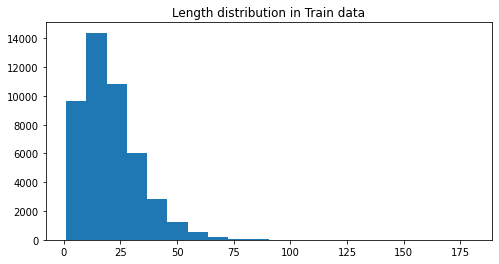

In [208]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

Для обучения `BiLSTM` лучше использовать colab

In [209]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Для более быстрого и устойчивого обучения сгруппируем наши данные по батчам

In [210]:
# бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [117]:
# посмотрим  на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[1434, 180, 180]

### Модель и её обучение

Инициализируем нашу модель

In [211]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, dropout, 
                  pad_idx, bidirectional, n_layers):
        super().__init__()
        
        self.bidirectional = bidirectional
        self.embeddings = nn.Embedding(input_dim, emb_dim, padding_idx = pad_idx)
        self.dropout = nn.Dropout(p=dropout)
        
        self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, 
                          dropout=dropout*(n_layers > 1), bidirectional=self.bidirectional)
        # если bidirectional, то предсказываем на основе конкатенации двух hidden
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)

    def forward(self, sent):
        
        #sent = [sent len, batch size] 
        # не забываем применить dropout к embedding
        embedded = self.embeddings(sent)
        embedded = self.dropout(embedded)

        #embedded = [sent_len, batch_size, emb_dim]
        
        output, (_, _) = self.lstm(embedded)
        #output = [sent len, batch size, hid dim * n directions]
        
        output = self.tag(self.dropout(output))

        return output
        
# параметры модели
INPUT_DIM = len(WORD.vocab)
OUTPUT_DIM = len(TAG.vocab)
EMB_DIM = 100
HID_DIM = 256
DROPOUT = 0.2
BIDIRECTIONAL = True
N_LAYERS = 2
PAD_IDX = WORD.vocab.stoi[WORD.pad_token]


model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, 
                   DROPOUT,  PAD_IDX, BIDIRECTIONAL, N_LAYERS).to(device)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(44814, 100, padding_idx=1)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(100, 256, num_layers=2, dropout=0.2, bidirectional=True)
  (tag): Linear(in_features=512, out_features=13, bias=True)
)

Подсчитаем количество обучаемых параметров нашей модели

In [199]:
def count_parameters(model):
  count = 0
  for parameter in model.parameters():
    if parameter.requires_grad == True:
      count += 1
  return count

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 19 trainable parameters


In [212]:
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        features = batch.words
        target = batch.tags  

        optimizer.zero_grad()
        
        output = model(features)

        #tags = [sent len, batch size]
        #output = [sent len, batch size, output dim]
        
        output = output.permute(1, 2, 0)
        target = target.permute(1, 0)
        
        #tags = [batch size, sent len]
        #output = [batch size, output dim, sent len]
        
        loss = criterion(output, target)
        
        loss.backward()
        
        # Gradient clipping(решение проблемы взрыва градента), clip - максимальная норма вектора
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            features = batch.words
            target = batch.tags

            output = model(features)

            #tags = [sent len, batch size]
            #output = [sent len, batch size, output dim]

            output = output.permute(1, 2, 0)
            target = target.permute(1, 0)

            #tags = [batch size, sent len]
            #output = [batch size, output dim, sent len]

            loss = criterion(output, target)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

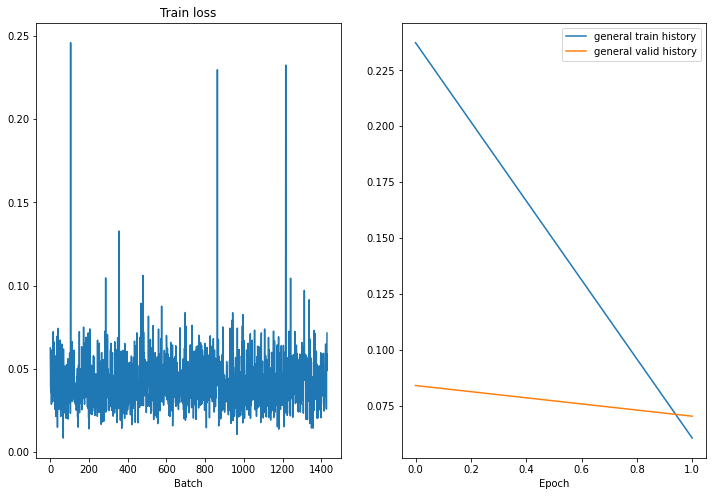

Epoch: 03 | Time: 1m 13s
	Train Loss: 0.042 | Train PPL:   1.043
	 Val. Loss: 0.071 |  Val. PPL:   1.074


In [213]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 3
CLIP = 1.0
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    # break
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

### Применение модели

In [172]:
def accuracy_model(model, iterator):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            features = batch.words
            target = batch.tags

            output = model(features)
            
            #output = [sent len, batch size, output dim]
            output = torch.argmax(torch.softmax(output, dim=2), dim=2)
            
            #output = [sent len, batch size]
            predict_tags = output.cpu().numpy()
            true_tags = target.cpu().numpy()

            true_pred += np.sum((true_tags == predict_tags) & (true_tags != PAD_IDX))
            num_pred += np.prod(true_tags.shape) - (true_tags == PAD_IDX).sum()
        
    return round(true_pred / num_pred * 100, 3)

Точность на всей выборке (число эпох 3)

In [214]:
# точность  на всей выборке
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 97.673 %


Можете улучшить качество, изменяя параметры модели. Но чтобы добиться нужного качества, неообходимо взять всю выборку, а не только категорию `humor`.

In [141]:
best_model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, 
                   DROPOUT,  PAD_IDX, BIDIRECTIONAL, N_LAYERS).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))
assert accuracy_model(best_model, test_iterator) >= 92

Пример решение нашей задачи:

In [142]:
def print_tags(model, data):
    model.eval()
    
    with torch.no_grad():
        words, _ = data
        example = torch.LongTensor([WORD.vocab.stoi[elem] for elem in words]).unsqueeze(1).to(device)
        
        output = model(example).argmax(dim=-1).cpu().numpy()
        tags = [TAG.vocab.itos[int(elem)] for elem in output]

        for token, tag in zip(words, tags):
            print(f'{token:15s}{tag}')

In [143]:
print_tags(model, pos_data[-1])

From           NOUN
what           DET
I              NOUN
was            VERB
able           ADJ
to             ADP
gauge          NOUN
in             ADP
a              DET
swift          ADJ
,              .
greedy         ADJ
glance         NOUN
,              .
the            DET
figure         NOUN
inside         ADP
the            DET
coral-colored  ADJ
boucle         NOUN
dress          NOUN
was            VERB
stupefying     VERB
.              .


Точность на категории humor (число эпох 8)

In [189]:
brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')

In [202]:
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 91.884 %


In [160]:
print_tags(model, pos_data[-1])

From           ADV
what           DET
I              NOUN
was            VERB
able           ADJ
to             ADP
gauge          NOUN
in             ADP
a              DET
swift          ADJ
,              .
greedy         ADJ
glance         NOUN
,              .
the            DET
figure         NOUN
inside         ADP
the            DET
coral-colored  ADJ
boucle         NOUN
dress          NOUN
was            VERB
stupefying     VERB
.              .


## Сравните результаты моделей HiddenMarkov, LstmTagger:
* при обучение на маленькой части корпуса, например, на категории humor
* при обучении на всем корпусе

In [ ]:
Точность на всей выборке HiddenMarkovModel составила около 97.78%
                         BiLSTM (3 эпохи)  cоставила около 96.2%

Точность на категории humor  HiddenMarkovModel составила около 88.8%
                             BiLSTM (8 эпох)   cоставила около 91.8%